** Segmentation using Fully Convolutional Neural Networks **

https://github.com/m2dsupsdlclass/lectures-labs

Let's see if we can use a pre-trained deep convolutional neural network to do some simple image segmentation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize

In [2]:
# Load the pre-trained ResNet50 network
from keras.applications.resnet50 import ResNet50

# We strip off the fully-connected top layer, which
# also allows our model to have variable input shape
base_model = ResNet50(include_top=False)

Using TensorFlow backend.


Let's take a look at what the ResNet50 model architecture looks like.

In [3]:
print base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

The default ImageNet input is `224 x 224`, and the output size of the `res5c` residual block will be `7 x 7 x 2048`. After this block, there is an average pooling layer, which divides both the width and height dimensions by 7, giving rise to a `1 x 1 x 2048` output.

In [4]:
# res5c layer
res5c = base_model.layers[-2]
type(res5c)

keras.layers.core.Activation

In [5]:
res5c.output_shape

(None, None, None, 2048)

In [6]:
# average pooling layer
avg_pool = base_model.layers[-1]
type(avg_pool)

keras.layers.pooling.AveragePooling2D

In [7]:
avg_pool.output_shape

(None, None, None, 2048)

In [8]:
avg_pool.pool_size, avg_pool.strides

((7, 7), (7, 7))

The regular resnet model has the following layers:

```
x = res5c (activation + avg_pool)
x = Flatten()(x)
x = Dense(1000)(x)
x = Softmax()(x)
```

In order to transform this model into a fully convolutional neural network, we need to do three things:

* To preserve spatial information, we will remove the average pooling layer

* We will change the Dense layer on top to a Convolution2D layer to keep the spatial information and output a `W x H x 1000` tensor

* We will also define a custom Keras layer for computing the soft max on the last dimension of a tensor

In [9]:
import keras
from keras.engine import Layer
import keras.backend as K

# A custom layer in Keras must implement the four following methods:
class SoftmaxMap(Layer):
    # Init function
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(SoftmaxMap, self).__init__(**kwargs)

    # There are no parameters, so we don't need this one
    def build(self,input_shape):
        pass

    # This is the layer we're interested in: 
    # very similar to the regular softmax but note that additionally
    # that we accept x.shape == (batch_size, w, h, n_classes),
    # which is not the case in Keras by default.
    def call(self, x, mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    # The output shape is the same as the input shape
    def compute_output_shape(self, input_shape):
        return input_shape

Now let's build our Conv2D layer. We will apply a 1x1 convolution (similar to the original Dense layer) to each spatial location.

In [10]:
from keras.layers import Convolution2D
from keras.models import Model

# Use the same input as the ResNet50 model
input = base_model.layers[0].input

# Take the output of the layer just before the AveragePooling2D
# layer:
x = base_model.layers[-2].output

# A 1x1 convolution, with 1000 output channels, one per class
x = Convolution2D(1000, (1, 1), name='conv1000')(x)

# Softmax on last axis of tensor to normalize the class
# predictions in each spatial area
output = SoftmaxMap(axis=-1)(x)

fully_conv_ResNet = Model(inputs=input, outputs=output)

Let's check that our custom soft max layer can compute class probabilities across the last dimension of a tensor by using some random data that is formatted in the shape of images.

In [11]:
prediction_maps = fully_conv_ResNet.predict(np.random.randn(1, 200, 300, 3))
prediction_maps.shape

(1, 7, 10, 1000)

Across all spatial locations, check that the last dimension (probabilities over classes) approximately sums to one.

In [12]:
prediction_maps.sum(axis=-1)

array([[[ 1.        ,  0.99999988,  1.00000024,  0.99999988,  1.00000012,
          0.99999976,  1.        ,  0.99999994,  0.99999982,  1.00000024],
        [ 1.        ,  1.        ,  1.        ,  0.99999994,  1.00000012,
          1.        ,  0.99999988,  1.        ,  0.99999988,  1.        ],
        [ 0.99999982,  1.        ,  1.00000024,  0.99999976,  0.99999994,
          1.        ,  1.        ,  0.99999982,  1.00000024,  1.00000012],
        [ 0.99999976,  1.        ,  1.        ,  1.        ,  1.        ,
          1.00000024,  1.        ,  0.99999988,  1.00000012,  1.        ],
        [ 0.99999976,  1.00000024,  1.        ,  1.        ,  0.99999994,
          1.        ,  0.99999994,  1.        ,  0.99999994,  1.00000024],
        [ 1.        ,  1.        ,  1.00000012,  0.99999988,  0.99999988,
          1.        ,  1.        ,  0.99999988,  1.        ,  0.99999988],
        [ 0.99999994,  1.        ,  1.        ,  0.99999994,  1.        ,
          0.99999994,  1.0000002

Now let's get the dense weights for the 1x1 Convolution2D layer. We'll have to reload the ResNet50 model, but this time also include the top layer.

In [13]:
# load ResNet50 again, but this time with the top dense layer
model = ResNet50(include_top=True)
dense = model.layers[-1]

# get the weights and change their shape to have the same shape as the Conv2D layer
w, b = dense.get_weights()
w = w.reshape((1, 1, 2048, 1000))

Now, let's change the weights of our dummy Conv2D layer to that of the original Dense layer.

In [14]:
last_layer = fully_conv_ResNet.layers[-2]
last_layer.set_weights([w, b])

Let's define a function that will take an image, resize it, and feed it through our new fully convolutional neural network.

In [15]:
from scipy.misc import imread, imresize
from keras.applications.imagenet_utils import preprocess_input

def forward_pass_resize(img_path, img_size):
    img_raw = imread(img_path)
    print "img shape before resizing: %s" % (img_raw.shape,) 
    img = imresize(img_raw, size=img_size).astype("float32")
    img = preprocess_input(img[np.newaxis])
    print "img batch size shape before forward pass:", img.shape 
    z = fully_conv_ResNet.predict(img)
    return z

Here we feed our model an image of a dog.

In [16]:
output = forward_pass_resize("dog.jpg", (800, 600))
print "prediction map shape", output.shape 

img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 800, 600, 3)
prediction map shape (1, 25, 19, 1000)


From the forward pass through our network, we have a `25 x 19 x 1000` tensor representing the output. At each spatial location, we have a probability that this location belongs to some object class. Let's find all dog-related classes using the `imagenet_tool` helper functions.

In [17]:
import imagenet_tool
synset = "n02084071" # synset corresponding to dogs in the ImageNet
ids = imagenet_tool.synset_to_dfs_ids(synset)
print "All dog classes ids (%d):" % len(ids)
print ids

All dog classes ids (118):
[251, 268, 256, 253, 255, 254, 257, 159, 211, 210, 212, 214, 213, 216, 215, 219, 220, 221, 217, 218, 207, 209, 206, 205, 208, 193, 202, 194, 191, 204, 187, 203, 185, 192, 183, 199, 195, 181, 184, 201, 186, 200, 182, 188, 189, 190, 197, 196, 198, 179, 180, 177, 178, 175, 163, 174, 176, 160, 162, 161, 164, 168, 173, 170, 169, 165, 166, 167, 172, 171, 264, 263, 266, 265, 267, 262, 246, 242, 243, 248, 247, 229, 233, 234, 228, 231, 232, 230, 227, 226, 235, 225, 224, 223, 222, 236, 252, 237, 250, 249, 241, 239, 238, 240, 244, 245, 259, 261, 260, 258, 154, 153, 158, 152, 155, 151, 157, 156]


Let's take a look at a few samples of breeds of dogs that these ids correspond to.

In [18]:
for dog_id in ids[:10]:
    print imagenet_tool.id_to_words(dog_id)

dalmatian, coach dog, carriage dog
Mexican hairless
Newfoundland, Newfoundland dog
basenji
Leonberg
pug, pug-dog
Great Pyrenees
Rhodesian ridgeback
vizsla, Hungarian pointer
German short-haired pointer


Now comes the fun part! Let's build a function that will create a heatmap of the image corresponding to a given synset in ImageNet (e.g. dogs). We can also show the original image alongside the heatmap.

In [19]:
# build a heat map given a synset
def build_heatmap(z, synset):
    ids = imagenet_tool.synset_to_dfs_ids(synset)
    ids = np.array([id_ for id_ in ids if id_ is not None])
    x = z[0, :, :, ids].sum(axis=0)
    print("size of heatmap: " + str(x.shape))
    return x

# display the original image and corresponding heat map
def display_img_and_heatmap(img_path, heatmap):
    img = imread(img_path)
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, interpolation='nearest', cmap="viridis")
    plt.axis('off')

We can use multiple scales to get a better estimate of the final heat map. Here, we will use three different image sizes (`400 x 640`, `800 x 1280`, and `1600 x 2560`) and combine them to form a final heat map.

img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 400, 640, 3)
size of heatmap: (13, 20)
img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 800, 1280, 3)
size of heatmap: (25, 40)
img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 1600, 2560, 3)
size of heatmap: (50, 80)


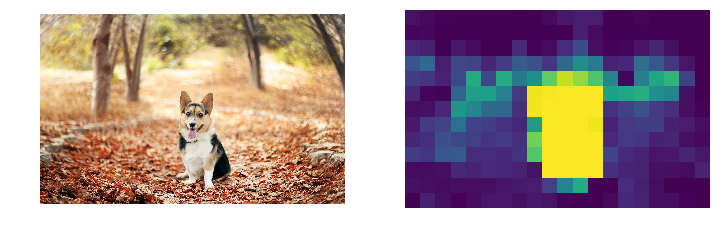

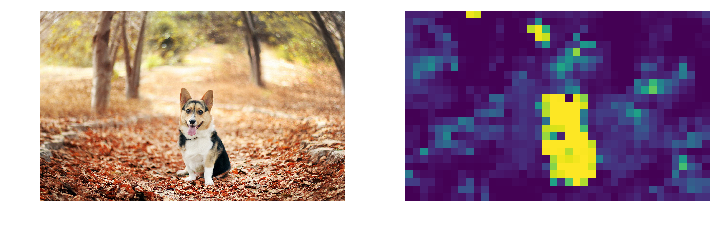

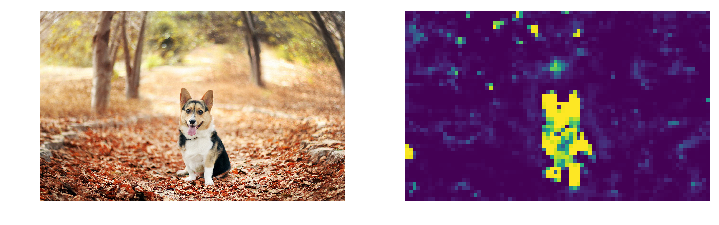

In [20]:
s = "n02084071"

probas_1 = forward_pass_resize("dog.jpg", (400, 640))
heatmap_1 = build_heatmap(probas_1, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_1)

probas_2 = forward_pass_resize("dog.jpg", (800, 1280))
heatmap_2 = build_heatmap(probas_2, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_2)

probas_3 = forward_pass_resize("dog.jpg", (1600, 2560))
heatmap_3 = build_heatmap(probas_3, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_3)

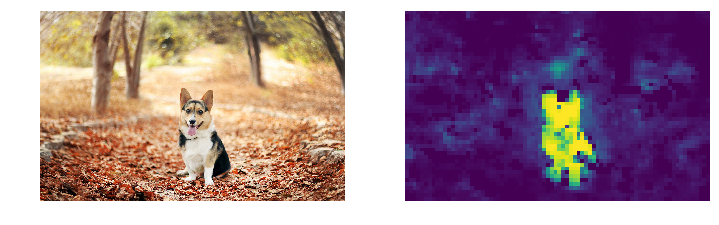

In [21]:
# Combine heat maps at the highest resolution scale by taking a geometric average
heatmap_1_r = imresize(heatmap_1, (50,80)).astype("float32")
heatmap_2_r = imresize(heatmap_2, (50,80)).astype("float32")
heatmap_3_r = imresize(heatmap_3, (50,80)).astype("float32")

heatmap_geom_avg = np.power(heatmap_1_r * heatmap_2_r * heatmap_3_r, 0.333)
display_img_and_heatmap("dog.jpg", heatmap_geom_avg)